In [8]:
import numpy as np
import cvxpy as cp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import weibull_min
import cyipopt

In [9]:
def xlog_exp(x,a,b):
    if x > 0 :
        e = np.exp(1)
        c1 = b**2*(a**2+a)*np.exp(a-1)
        c2 = c1 - np.exp(a)*(a*b+1)
        c3 = np.exp(a+1)
        term1 = (x+e)*np.exp(a*np.log(x+e)**b) 
        print(1/c1,c2/c1,-c3/c1)
        return(1/c1*(term1 +c2*x-c3))
    else:
        return(np.exp(x)-1)
    
def dlog_exp(x,a,b):
    if x > 0:
        e = np.exp(1)
        c1 = b**2*(a**2+a)*np.exp(a-1)
        c2 = c1 - np.exp(a)*(a*b+1)
        term1 = np.exp(a*np.log(x+e)**b)*(a*b*np.log(x+e)**(b-1)+1)
        return((1/c1)*(term1+c2))
    else:
        return(np.exp(x))
def ddlog_exp(x,a,b):
    if x > 0:
        e = np.exp(1)
        c1 = b**2*(a**2+a)*np.exp(a-1)
        c2 = c1 - np.exp(a)*(a*b+1)
        term1 = a*b*(np.log(x+e))**b+b+np.log(x+e)-1
        term2 = a*b*np.exp(a*(np.log(x+e))**b)*(np.log(x+e))**(b-2)
        return((1/c1)*(term1*term2/(x+e)))
    else:
        return(np.exp(x))
def d1dl(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        fac1 = -(s_vec[i]+t1)/(lbda**2)
        fac2 = 1/N*ddlog_exp((s_vec[i]+t1)/lbda,a,b)
        som = som + fac1*fac2 
    return(som)

def d1ds(t1,s,lbda,a,b,N):
    return(1/N*ddlog_exp((s+t1)/lbda,a,b)*1/lbda)

def dsdl(t1,s,lbda,a,b,N):
    return(1/N*(-s-t1)/(lbda**2)*ddlog_exp((s+t1)/lbda,a,b))

def dl2(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        som = som + (s_vec[i]+t1)**2/(lbda**3)*ddlog_exp((s_vec[i]+t1)/lbda,a,b)
    return(som/N)

def dt_12(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        som = som + ddlog_exp((s_vec[i]+t1)/lbda,a,b)/lbda
    return(som/N)
def ds2(t1,s,lbda,a,b,N):
    return(1/N*ddlog_exp((s+t1)/lbda,a,b)*1/lbda)
    
def cvar_conj(x,alpha):
    return(np.maximum(1/alpha*x,0))
    #return(1/alpha *x)

def dcvar_conj(x,alpha):
    if x>0:
        return(1/alpha)
    else:
        return(0)
    #return(1/alpha)

def q_wc(x,the1, the2,lbda,a,b,alpha):
    arg = (cvar_conj((the2-x),alpha)+the1)/lbda
    return(dlog_exp(arg,a,b))

def qb_wc(x,the1, the2,lbda,a,b,alpha):
    arg = q_wc(x,the1, the2,lbda,a,b,alpha)
    return(arg*dcvar_conj(the2-x,alpha))
    
def qqb_wc(x,the1, the2,lbda,a,b,alpha):
    term1 = (the1 + cvar_conj(the2-x,alpha))/lbda
    term2 = q_wc(x,the1, the2,lbda,a,b,alpha)
    term3 = xlog_exp(term1,a,b)
    return(term1*term2-term3)

def fvalue (x,*data):
    X,a,b,alpha,r = data
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(N):
        s1 = s1 + q_wc(X[i],the1, the2,lbda,a,b,alpha)
        s2 = s2 + qb_wc(X[i],the1, the2,lbda,a,b,alpha)
        s3 = s3 + qqb_wc(X[i],the1, the2,lbda,a,b,alpha)
    return(s1/N-1,s2/N-1,s3/N-r)
        

In [10]:
xlog_exp(0.1, 0.1,2)

5.590007070811249 -6.413495895797396 -16.79330931575148


0.10499006056507311

In [11]:
def d1(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term1 = cvar_conj(t2-X[i],alpha)
        som = som + 1/N * dlog_exp((term1+t1)/lbda,a,b)
    return(-1+som)

def d2(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term1 = cvar_conj(t2-X[i],alpha)
        som = som + 1/N* dlog_exp((term1+t1)/lbda,a,b)*dcvar_conj(t2-X[i],alpha)
    return(-1+som)

def dl(t1,t2,lbda,a,b,r,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        arg = (term0+t1)/lbda
        term1 = xlog_exp(arg,a,b) - dlog_exp(arg,a,b)*arg
        som = som + 1/N* term1
    return(r+som)

def d11(t1,t2,lbda,a,b,alpha,X):
    som = 0
    N = len(X)
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        som = som + ddlog_exp((term0 + t1)/lbda,a,b)/lbda
    return(som/N)

def d12(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        som = som + ddlog_exp((term0 + t1)/lbda,a,b)/lbda*dcvar_conj(t2-X[i],alpha)
    return(som/N)

def d1l(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        fac1 = -(term0+t1)/(lbda**2)
        fac2 = 1/N*ddlog_exp((term0+t1)/lbda,a,b)
        som = som + fac1*fac2 
    return(som/N)

def d22(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        som = som + ddlog_exp((term0 + t1)/lbda,a,b)/lbda *1/alpha*dcvar_conj(t2-X[i],alpha)
    return(som/N)

def d2l(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        som = som + ddlog_exp((term0 + t1)/lbda,a,b)*(-(term0+t1)/lbda**2)*dcvar_conj(t2-X[i],alpha)
    return(som/N)

def dll(t1,t2,lbda,a,b,alpha,X):
    N = len(X)
    som = 0
    for i in range(N):
        term0 = cvar_conj(t2-X[i],alpha)
        som = som + (term0+t1)**2/(lbda**3)*ddlog_exp((term0+t1)/lbda,a,b)
    return(som/N)
 
    

In [12]:
from scipy.optimize import fsolve
a = 0.001
b = 2
alpha = 0.025
r = 0.001
data = (X, a,b,alpha,r)
initial_guess = z  # Initial guess for the root
fsolve(fvalue, initial_guess, args=data, full_output=True)


NameError: name 'X' is not defined

In [169]:
fvalue (z,*data)

(0.00020008230242019032, -1.0, -0.0009999799834577712)

In [13]:
np.random.seed(3)
X = -(np.random.lognormal(0,1,size= 5))
a = 0.01
b = 2
alpha = 0.5
r = 0.1
para = [a,b,alpha,r]
f = np.zeros(len(X)) + 1/len(X)

In [242]:
X

array([-5.9812434 , -1.54729748, -1.10130679, -0.15512986, -0.75776028,
       -0.70134246, -0.92058911, -0.53419161, -0.95712798, -0.62050723,
       -0.26877928, -2.4220696 , -2.41407947, -5.52660147, -1.05130646,
       -0.667192  , -0.57963311, -0.21299697, -2.67077164, -0.33251589,
       -0.30573195, -0.81411805, -4.42003827, -1.26708155, -0.35923262,
       -0.49017481, -1.86870367, -0.85170644, -0.46355217, -0.79450919,
       -2.10655996, -7.21462909, -0.28819345, -0.53450355, -0.44763993,
       -0.08900318, -0.39701071, -0.35920007, -3.07707035, -0.87641616])

In [14]:
def kl_cvar_ball(alpha,x,f,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    w = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    som = 0
    for i in range(n):
        #if wbln_factor(-x[i],0,np.sqrt(1.5)) >= 1e-5:
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append((w[i] - lbda) <= t[i])   #2/(-x[i])*
        constraints.append(cp.kl_div(lbda,w[i])+lbda+s[i]-w[i]<= 0)
        som = som + t[i]*f[i]
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

In [7]:
[obj,x_s1, x_s2, x_s3] = kl_cvar_ball(alpha,X,f,r)

In [8]:
print(obj, x_s1,x_s2,x_s3)

5.0519835394916175 [-2.58237859] [-1.5472973] [9.22932021]


In [189]:
X

array([-5.9812434 , -1.54729748])

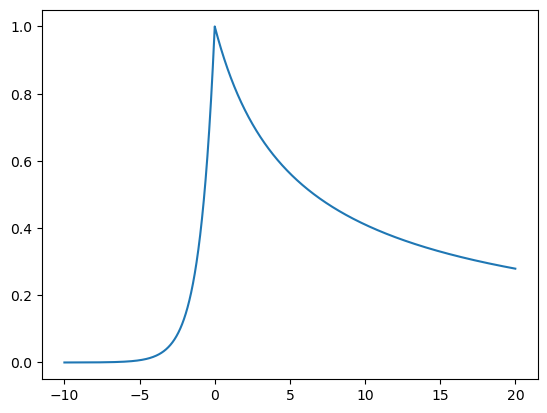

In [24]:
x = np.arange(-10,20,0.01)
y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = ddlog_exp(x[i],a,b)
plt.plot(x,y)

In [15]:
##### Ipopt with dummy variables


class HS071():
    
    def __init__(self, X, para):
        self.X = X  # Store X as an instance attribute
        self.para = para

    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(x)-3
        som = 0
        for i in range(3,len(x)):
            som = som + lbda * xlog_exp((x[i]+the1)/lbda,a,b)
        som = som/N - the1 -the2 + lbda*r
        return(som)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(x)-3
        s1 = 0
        s2 = 0
        grad = np.zeros(len(x))
        grad[1] = -1  
        for i in range(3,len(x)):
            grad[i] = dlog_exp((x[i]+the1)/lbda,a,b)/N
            s1 = s1 + dlog_exp((x[i]+the1)/lbda,a,b)/N
            s2 = s2 + xlog_exp((x[i]+the1)/lbda,a,b)/N - dlog_exp((x[i]+the1)/lbda,a,b)/N * ((x[i]+the1)/lbda)
        grad[0] = -1 + s1
        grad[2] = r + s2
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        a,b,alpha,r = self.para
        N = len(self.X)
        cons = np.zeros(N)
        for i in range(N):
            cons[i] = 1/alpha * (x[1]-self.X[i])-x[i+3] 
        
        return(cons)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        a,b,alpha,r = self.para
        N = len(self.X)
        jacob = np.zeros(len(x))
        jacob[1] = 1/alpha
        for i in range(3,len(x)):
            jacob[i] = -1
        jacob = np.array([jacob])
        
        row, col = self.jacobianstructure()
        return(jacob[row,col])
    def jacobianstructure(self):
        N = len(self.X)
        jac_struc = np.zeros(N+3)+1
        jac_struc[0] = 0
        jac_struc[2] = 0
        jac_struc = np.array([jac_struc])
        return(np.nonzero(jac_struc))
        
        
    
    
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        a,b,alpha,r = self.para
        N = len(self.X)
        struc = np.tril(np.ones((N+3,N+3)))
        struc[1,:] = 0
        struc[0:N+3,1] = 0
        for i in range(3,N+1):
            struc[(i+1):(N+3),i] = 0
        struc[N+2,N+1] = 0
        return np.nonzero(struc)

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        a,b,alpha,r = self.para
        N = len(self.X)
        H = np.zeros((N+3,N+3))
        s_vec = x[3:len(x)]
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        H[0,0] = dt_12(t1,s_vec,lbda,a,b,N)
        H[2,0] = d1dl(t1,s_vec,lbda,a,b,N)
        H[2,2] = dl2(t1,s_vec,lbda,a,b,N)
        for i in range(3,len(x)):
            H[i,0] = d1ds(t1,x[i],lbda,a,b,N)
            H[i,2] = dsdl(t1,x[i],lbda,a,b,N)
            H[i,i] = ds2(t1,x[i],lbda,a,b,N)

        H = obj_factor*H

        row, col = self.hessianstructure()

        return H[row, col]


    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""

        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print(iter_count, inf_pr)
     

In [10]:
##### Ipopt without dummy variables


class HS072():
    
    def __init__(self, X, para):
        self.X = X  # Store X as an instance attribute
        self.para = para

    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        a,b,alpha,r = self.para
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        N = len(self.X)
        som = 0
        for i in range(N):
            term0 = cvar_conj(t2-self.X[i],alpha)
            som = som + lbda * xlog_exp((term0 + t1)/lbda,a,b)
        som = som/N - t1 -t2 + lbda*r
        return(som)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        a,b,alpha,r = self.para
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        N = len(self.X)
        grad = np.zeros(3)
        grad[0] = d1(t1,t2,lbda,a,b,alpha,self.X)
        grad[1] = d2(t1,t2,lbda,a,b,alpha,self.X)
        grad[2] = dl(t1,t2,lbda,a,b,r,alpha,self.X)
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        cons = 1/2 *(x[0]**2 + x[1]**2 + x[2]**2)
        return(cons)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return(x) 
    
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        return np.nonzero(np.tril(np.ones((3,3))))

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        a,b,alpha,r = self.para
        N = len(self.X)
        H = np.zeros((3,3))
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        H[0,0] = d11(t1,t2,lbda,a,b,alpha,self.X) * obj_factor + lagrange[0]
        H[1,0] = d12(t1,t2,lbda,a,b,alpha,self.X) * obj_factor
        H[2,0] = d1l(t1,t2,lbda,a,b,alpha,self.X) * obj_factor
        H[1,1] = d22(t1,t2,lbda,a,b,alpha,self.X) * obj_factor + lagrange[0]
        H[1,2] = d2l(t1,t2,lbda,a,b,alpha,self.X) * obj_factor
        H[2,2] = dll(t1,t2,lbda,a,b,alpha,self.X) * obj_factor + lagrange[0]

        row, col = self.hessianstructure()

        return H[row, col]


    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""

        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print(iter_count, inf_pr)
     

In [11]:
class HS073(cyipopt.Problem):
    
    
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        som = 0
        for i in range(3,len(x)):
            som = som + lbda * xlog_exp((x[i]+the1)/lbda,a,b)
        som = som/N - the1 -the2 + lbda*r
        return(som)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        s1 = 0
        s2 = 0
        grad = np.zeros(len(x))
        grad[1] = -1  
        for i in range(3,len(x)):
            grad[i] = dlog_exp((x[i]+the1)/lbda,a,b)/N
            s1 = s1 + dlog_exp((x[i]+the1)/lbda,a,b)/N
            s2 = s2 + xlog_exp((x[i]+the1)/lbda,a,b)/N - dlog_exp((x[i]+the1)/lbda,a,b)/N * ((x[i]+the1)/lbda)
        grad[0] = -1 + s1
        grad[2] = r + s2
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        #a,b,alpha,r = self.para
        N = len(X)
        cons = np.zeros(N)
        for i in range(N):
            cons[i] = 1/alpha * (x[1]-X[i])-x[i+3] 
        
        return(cons)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        #a,b,alpha,r = self.para
        N = len(X)
        jacob = np.zeros(len(x))
        jacob[1] = 1/alpha
        for i in range(3,len(x)):
            jacob[i] = -1
        jacob = np.array([jacob])
        
        row, col = self.jacobianstructure()
        return(jacob[row,col])
    def jacobianstructure(self):
        N = len(X)
        jac_struc = np.zeros(N+3)+1
        jac_struc[0] = 0
        jac_struc[2] = 0
        jac_struc = np.array([jac_struc])
        return(np.nonzero(jac_struc))
        
        
    
    
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        #a,b,alpha,r = self.para
        N = len(X)
        struc = np.tril(np.ones((N+3,N+3)))
        struc[1,:] = 0
        struc[0:N+3,1] = 0
        for i in range(3,N+1):
            struc[(i+1):(N+3),i] = 0
        struc[N+2,N+1] = 0
        return np.nonzero(struc)

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        #a,b,alpha,r = self.para
        N = len(X)
        H = np.zeros((N+3,N+3))
        s_vec = x[3:len(x)]
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        H[0,0] = dt_12(t1,s_vec,lbda,a,b,N)
        H[2,0] = d1dl(t1,s_vec,lbda,a,b,N)
        H[2,2] = dl2(t1,s_vec,lbda,a,b,N)
        for i in range(3,len(x)):
            H[i,0] = d1ds(t1,x[i],lbda,a,b,N)
            H[i,2] = dsdl(t1,x[i],lbda,a,b,N)
            H[i,i] = ds2(t1,x[i],lbda,a,b,N)

        H = obj_factor*H

        row, col = self.hessianstructure()

        return H[row, col]


    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""
        iterate = self.get_current_iterate()
        infeas = self.get_current_violations()
        primal = iterate["x"]
        jac = self.jacobian(primal)
        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print("Primal iterate:", primal[0:5])
        infeasi = []
        for i in range(len(X)):
            infeasi.append(1/alpha * (primal[1]-X[i])-primal[3+i])
        print('infeasi:', np.max(infeasi))
        print('inf_pr:', inf_pr)
        #print("Flattened Jacobian:", jac)
        #print("Dual infeasibility:", infeas["grad_lag_x"])

In [22]:
def kl_c(x):
    return(np.exp(x)-1)

def d_kl_c(x):
    return(np.exp(x))

def dd_kl_c(x):
    return(np.exp(x))

def kl_d1dl(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        fac1 = -(s_vec[i]+t1)/(lbda**2)
        fac2 = 1/N*dd_kl_c((s_vec[i]+t1)/lbda)
        som = som + fac1*fac2 
    return(som)

def kl_d1ds(t1,s,lbda,a,b,N):
    return(1/N*dd_kl_c((s+t1)/lbda)*1/lbda)

def kl_dsdl(t1,s,lbda,a,b,N):
    return(1/N*(-s-t1)/(lbda**2)*dd_kl_c((s+t1)/lbda))

def kl_dll(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        som = som + (s_vec[i]+t1)**2/(lbda**3)*dd_kl_c((s_vec[i]+t1)/lbda)
    return(som/N)

def kl_d11(t1,s_vec,lbda,a,b,N):
    som = 0
    for i in range(N):
        som = som + dd_kl_c((s_vec[i]+t1)/lbda)/lbda
    return(som/N)
def kl_dss(t1,s,lbda,a,b,N):
    return(1/N*dd_kl_c((s+t1)/lbda)*1/lbda)

In [23]:
###### Robust KL-CVaR

class HS074(cyipopt.Problem):
    
    
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        som = 0
        for i in range(3,N+3):
            som = som + lbda * kl_c((x[i]+the1)/lbda)
        return(-x[0]-x[1]+x[2]*r+som)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        s1 = 0
        s2 = 0
        grad = np.zeros(N+3)
        grad[1] = -1  
        for i in range(3,N+3):
            grad[i] = d_kl_c((x[i]+the1)/lbda)/N
            s1 = s1 + d_kl_c((x[i]+the1)/lbda)/N
            s2 = s2 + kl_c((x[i]+the1)/lbda) - d_kl_c((x[i]+the1)/lbda)*((x[i]+the1)/lbda)
        grad[0] = -1 + s1
        grad[2] = r + s2/N
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        #a,b,alpha,r = self.para
        N = len(X)
        cons = np.zeros(N)
        for i in range(N):
            cons[i] = 1/alpha*(x[1]-X[i])-x[i+3] 
        
        return(cons)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        #a,b,alpha,r = self.para
        N = len(X)
        jacob = np.zeros(N+3)
        jacob[1] = 1/alpha
        for i in range(3,N+3):
            jacob[i] = -1
        jacob = np.array([jacob])
        
        row, col = self.jacobianstructure()
        return(jacob[row,col])
    def jacobianstructure(self):
        N = len(X)
        jac_struc = np.zeros(N+3)+1
        jac_struc[0] = 0
        jac_struc[2] = 0
        jac_struc = np.array([jac_struc])
        return(np.nonzero(jac_struc))
        
        
    
    
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        #a,b,alpha,r = self.para
        N = len(X)
        struc = np.tril(np.ones((N+3,N+3)))
        struc[1,:] = 0
        struc[0:N+3,1] = 0
        for i in range(3,N+1):
            struc[(i+1):(N+3),i] = 0
        struc[N+2,N+1] = 0
        return np.nonzero(struc)

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        #a,b,alpha,r = self.para
        N = len(X)
        H = np.zeros((N+3,N+3))
        s_vec = x[3:(N+3)]
        t1 = x[0]
        t2 = x[1]
        lbda = x[2]
        H[0,0] = kl_d11(t1,s_vec,lbda,a,b,N)
        H[2,0] = kl_d1dl(t1,s_vec,lbda,a,b,N)
        H[2,2] = kl_dll(t1,s_vec,lbda,a,b,N)
        for i in range(3,N+3):
            H[i,0] = kl_d1ds(t1,x[i],lbda,a,b,N)
            H[i,2] = kl_dsdl(t1,x[i],lbda,a,b,N)
            H[i,i] = kl_dss(t1,x[i],lbda,a,b,N)

        H = obj_factor*H

        row, col = self.hessianstructure()

        return H[row, col]


    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""
        iterate = self.get_current_iterate()
        infeas = self.get_current_violations()
        primal = iterate["x"]
        jac = self.jacobian(primal)
        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print("Primal iterate:", primal)
        #infeasi = []
        #for i in range(len(X)):
        #    infeasi.append(1/alpha * (primal[1]-X[i])-primal[3+i])
       # print('infeasi:', np.max(infeasi))
        print('inf_pr:', inf_pr)
        #print("Flattened Jacobian:", jac)
        #print("Dual infeasibility:", infeas["grad_lag_x"])

In [14]:
#### robust EU

class HS075(cyipopt.Problem):
    
    
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        lbda = x[1]
        N = len(X)
        som = 0
        for i in range(2,N):
            som = som + lbda * kl_c((the1-X[i])/lbda)
        som = som/N - the1 + lbda*r
        return(som)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        #a,b,alpha,r = self.para
        the1 = x[0]
        lbda = x[1]
        N = len(X)
        s1 = 0
        s2 = 0
        grad = np.zeros(2)  
        for i in range(N):
            s1 = s1 + d_kl_c((the1-X[i])/lbda)/N
            s2 = s2 + kl_c((the1-X[i])/lbda)/N - d_kl_c((the1-X[i])/lbda)/N * ((the1-X[i])/lbda)
        grad[0] = -1 + s1
        grad[1] = r + s2
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        cons = x[1]
        return(cons)

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return(np.array([0,1])) 
        
    
    
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        #a,b,alpha,r = self.para
        N = len(X)
        struc = np.tril(np.ones((2,2)))
        return np.nonzero(struc)

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        #a,b,alpha,r = self.para
        N = len(X)
        H = np.zeros((2,2))
        t1 = x[0]
        lbda = x[1]
        s1 = 0
        s2 = 0
        s3 = 0
        for i in range(N):
            s1 = s1 + dd_kl_c((t1-X[i])/lbda)/lbda
            s2 = s2 + (t1-X[i])**2/(lbda**3)*dd_kl_c((t1-X[i])/lbda)
            fac1 = -(t1-X[i])/(lbda**2)
            fac2 = 1/N*dd_kl_c((t1-X[i])/lbda)
            s3 = s3 + fac1*fac2
        H[0,0] = s1 * obj_factor + lagrange[0]
        H[1,1] = s2 * obj_factor + lagrange[0]
        H[1,0] = s3 * obj_factor

        row, col = self.hessianstructure()

        return H[row, col]


    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""
        iterate = self.get_current_iterate()
        infeas = self.get_current_violations()
        primal = iterate["x"]
        jac = self.jacobian(primal)
        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print("Primal iterate:", primal)
        print('inf_pr:', inf_pr)
        #print("Flattened Jacobian:", jac)
        #print("Dual infeasibility:", infeas["grad_lag_x"])

In [15]:
class HS076(cyipopt.Problem):
    
    
    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return(x[2]*kl_c((x[0]+x[3])/x[2])-x[0]-x[1]+x[2]*r)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        #a,b,alpha,r = self.para
        grad = np.zeros(4)
        grad[0] = np.exp((x[0]+x[3])/x[2])-1
        grad[1] = -1
        grad[2] = kl_c((x[0]+x[3])/x[2]) - np.exp((x[0]+x[3])/x[2])* ((x[0]+x[3])/x[2])+ x[2]*r
        grad[3] = np.exp((x[0]+x[3])/x[2])
        
        return(grad)
             
        
       
    def constraints(self, x):
        """Returns the constraints."""
        return([1/alpha*(x[1]+5.98)-x[3]])

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return([0,1/alpha,0,-1]) 
        
    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.
        #a,b,alpha,r = self.para
        struc = np.tril(np.ones((4,4)))
        return np.nonzero(struc)
    
    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        #a,b,alpha,r = self.para
        H = np.zeros((4,4))
        H[0,0] = 1/x[2]*np.exp((x[0]+x[3])/x[2])* obj_factor
        H[2,0] = -(x[3]+x[0])/(x[2]**2)*np.exp((x[0]+x[3])/x[2])* obj_factor
        H[3,0] = 1/x[2]*np.exp((x[0]+x[3])/x[2])* obj_factor
        H[2,2] = np.exp((x[0]+x[3])/x[2])*((x[0]+x[3])**2/(x[2]**3))* obj_factor
        H[3,2] = -(x[3]+x[0])/(x[2]**2)*np.exp((x[0]+x[3])/x[2])* obj_factor
        H[3,3] = 1/x[2]*np.exp((x[0]+x[3])/x[2])* obj_factor
        
        row, col = self.hessianstructure()
        return H[row, col]

    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""
        iterate = self.get_current_iterate()
        infeas = self.get_current_violations()
        primal = iterate["x"]
        jac = self.jacobian(primal)
        msg = "Objective value at iteration #{:d} is - {:g}"

        print(msg.format(iter_count, obj_value))
        print("Primal iterate:", primal)
        print('inf_pr:', inf_pr)
        #print("Flattened Jacobian:", jac)
        #print("Dual infeasibility:", infeas["grad_lag_x"])

In [258]:
m 

0.011100838259683056

In [17]:

lb = [-3,-2,9]
ub = [-1, -1, 10]


cl = []
cu = []
x0 = [-1,1,9.2]
N = len(X)
for i in range(3, N+3):
    lb.append(0)
    ub.append(1000)
    cl.append(-1000)
    cu.append(0.1)
    x0.append(np.maximum(1/alpha*(x0[1]-X[i-3]),0)+0.01)


In [81]:
x0

[0.1, -5.981243403948075, 1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [20]:
lb = [-1000,0.01]
ub = [1000, 100]


cl = [0]
cu = [100000]
x0 = [0.5,1.1]


In [130]:
lb = [-500,-500,0.01,0.01]
ub = [500,500,500,500]
cl = [-500]
cu = [0.1]
x0 = [1,X[0],1,1/alpha*(X[0]-X[0])]

In [120]:
1/alpha

40.0

In [18]:
nlp = HS071(
    n=len(x0),
    m=len(cl),
    lb=lb,
    ub=ub,
    cl=cl,
    cu=cu,
)
nlp.add_option('tol', 1e-8)
nlp.add_option('max_iter', 6000)

TypeError: HS071.__init__() got an unexpected keyword argument 'n'

In [242]:
nlp.hessian(x0)

TypeError: HS074.hessian() missing 2 required positional arguments: 'lagrange' and 'obj_factor'

In [226]:
x, info = nlp.solve(x0)

Objective value at iteration #0 is - -6.45437
Primal iterate: [-2.98000003 -1.99000002  9.00999991  0.1         0.1         0.1
  0.1         0.1       ]
inf_pr: 7.792486758496151
Objective value at iteration #1 is - -6.41187
Primal iterate: [-2.97926299 -1.99123752  9.01070894  0.11083756  0.11083756  0.11083756
  0.11083756  0.11083756]
inf_pr: 7.778881792400333
Objective value at iteration #2 is - 16.3566
Primal iterate: [-2.87657498 -1.95024176  9.11134996  4.78558965  4.78558965  4.78558965
  4.78558965  4.78558965]
inf_pr: 3.240967345337817
Objective value at iteration #3 is - 21.0331
Primal iterate: [-2.81252656 -1.88619383  9.19973504  5.47134373  5.47134373  5.47134373
  5.47134373  5.47134373]
inf_pr: 2.7430163113081543
Objective value at iteration #4 is - 24.8364
Primal iterate: [-2.83049181 -1.00886193  9.26778273  6.16552949  6.16552949  6.16552949
  6.16552949  6.16552949]
inf_pr: 3.850481021365007
Objective value at iteration #5 is - 35.0353
Primal iterate: [-2.85245989 

Objective value at iteration #46 is - 54.31
Primal iterate: [-2.99999816 -1.00000897  9.99999343  9.86222582  9.86222582  9.86222582
  9.86222582  9.86222582]
inf_pr: 0.00024768911203428
Objective value at iteration #47 is - 54.3105
Primal iterate: [-2.99999816 -1.00000897  9.99999343  9.86227536  9.86227536  9.86227536
  9.86227536  9.86227536]
inf_pr: 0.00019815099617294385
Objective value at iteration #48 is - 54.3109
Primal iterate: [-2.99999816 -1.00000897  9.99999343  9.86231499  9.86231499  9.86231499
  9.86231499  9.86231499]
inf_pr: 0.00015852056216592025
Objective value at iteration #49 is - 54.3112
Primal iterate: [-2.99999816 -1.00000897  9.99999343  9.86234669  9.86234669  9.86234669
  9.86234669  9.86234669]
inf_pr: 0.0001268162619105645
Objective value at iteration #50 is - 54.3114
Primal iterate: [-2.99999816 -1.00000897  9.99999343  9.86237205  9.86237205  9.86237205
  9.86237205  9.86237205]
inf_pr: 0.00010145285926631276
Objective value at iteration #51 is - 54.3116


In [236]:
info

{'x': array([-3.00000003, -1.        , 10.00000009,  9.86248676,  9.86248676,
         9.86248676,  9.86248676,  9.86248676]),
 'g': array([  0.10000004,  -8.7678918 ,  -9.65987318, -11.55222705,
        -10.34696622]),
 'obj_val': 54.31252316752683,
 'mult_g': array([3.97250090e-01, 2.80053588e-10, 2.54225404e-10, 2.12522716e-10,
        2.37336918e-10]),
 'mult_x_L': array([9.86250455e-01, 2.50590352e-09, 2.50590311e-09, 2.54084352e-10,
        2.54084352e-10, 2.54084352e-10, 2.54084352e-10, 2.54084352e-10]),
 'mult_x_U': array([1.25295176e-09, 2.05499822e-01, 2.76811275e-01, 2.53086415e-12,
        2.53086415e-12, 2.53086415e-12, 2.53086415e-12, 2.53086415e-12]),
 'status': 1,
 'status_msg': b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'}

In [81]:
r

0.001

In [104]:
nlp = cyipopt.Problem(
   n=len(x0),
   m=len(cl),
   problem_obj=HS071(X,para),
   lb=lb,
   ub=ub,
   cl=cl,
   cu=cu,
)

nlp.add_option('mu_strategy', 'adaptive')
nlp.add_option('tol', 1e-6)

NameError: name 'HS071' is not defined

In [21]:
0.707**2*2

0.9996979999999999

In [69]:
1/alpha*(0.5-X[0])

259.249736157923

In [24]:
import numpy as np

def gradient_descent_backtracking(func, grad_f, x0, alfa=0.1, beta=0.7, max_iter=100, tol=1e-6):
    x = x0
    for i in range(max_iter):
        gradient = grad_f(x)
        step_size = 1.0
        while func(x - step_size * gradient) > func(x) - alfa * step_size * np.linalg.norm(gradient,2)**2:
            step_size *= beta
        x = x - step_size * gradient
        print('obj:',func(x), 'grad_norm:',np.linalg.norm(gradient,2), 't:', step_size)
        if np.linalg.norm(gradient,2) < tol:
            break
    return x

# Example usage:

def log_bar(x):
    if x>0:
        return(-np.log(x))
    else:
        return(np.inf)

if __name__ == "__main__":
    # Define the function f(x) and its gradient grad_f(x)
    def func(x):
        mu = 0.01
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        som = 0
        sb_1 = 0
        for i in range(3,N+3):
            som = som + lbda * kl_c((x[i]+the1)/lbda)
            sb_1 = sb_1 +log_bar(x[i]-1/alpha * (x[1]-X[i-3])) + log_bar(x[i])
        return(-the1-the2+lbda*r+som/N +mu*sb_1+mu*log_bar(x[2]))
        

    def grad_f(x):
        # Replace this with the gradient of your actual function
        mu = 0.01
        the1 = x[0]
        the2 = x[1]
        lbda = x[2]
        N = len(X)
        s1 = 0
        s2 = 0
        sb1 = 0
        grad = np.zeros(N+3) 
        for i in range(3,N+3):
            grad[i] = d_kl_c((x[i]+the1)/lbda)/N-mu/(x[i]-1/alpha*(x[1]-X[i-3]))-mu/x[i]
            s1 = s1 + d_kl_c((x[i]+the1)/lbda)/N
            s2 = s2 + kl_c((x[i]+the1)/lbda) - d_kl_c((x[i]+the1)/lbda)*((x[i]+the1)/lbda)
            sb1 = sb1 + mu/(alpha*x[i]-x[1]+X[i-3])
        grad[1] = -1 + sb1
        grad[0] = -1 + s1
        grad[2] = r + s2/N - mu/lbda
        
        return(grad)


    


In [34]:
x0 = [-4,np.min(X),1]
N = len(X)
for i in range(3, N+3):
    x0.append(0.1)

In [26]:
gradient_descent_backtracking(func, grad_f, x0, alfa=0.4, beta=0.7, max_iter=500, tol=1e-6)

obj: 9.021700896104292 grad_norm: 1.5234234328794394 t: 0.05764800999999997
obj: 7.666817372272944 grad_norm: 1.396292027264688 t: 1.0
obj: 7.290348112830379 grad_norm: 1.272204290461535 t: 0.24009999999999992
obj: 7.1937142609886395 grad_norm: 1.162333841846327 t: 0.08235429999999996
obj: 7.141789798750256 grad_norm: 0.9979853286391682 t: 0.11764899999999995
obj: 7.055535510199991 grad_norm: 1.12820785590976 t: 0.08235429999999996
obj: 7.048184039000628 grad_norm: 1.602140307597879 t: 0.006782230728489994
obj: 7.0163796594811565 grad_norm: 0.8310423019452037 t: 0.05764800999999997
obj: 7.00912727166919 grad_norm: 2.6893762751580255 t: 0.002326305139872068
obj: 6.6287239064559795 grad_norm: 0.8249295927138163 t: 1.0
obj: 6.38293881366661 grad_norm: 1.0751534380353733 t: 0.24009999999999992
obj: 6.378581697016648 grad_norm: 1.6310840000200537 t: 0.003323293056960097
obj: 6.223655748685367 grad_norm: 0.5737746882403322 t: 1.0
obj: 6.110849898770839 grad_norm: 1.0018130299797834 t: 0.1176

array([-1.23601538, -3.98089986,  3.56012922,  4.02122149,  0.07035218,
        0.07020347,  0.07000234,  0.07011684])

In [33]:
np.random.seed(3)
X = -(np.random.lognormal(0,1,size= 5))
a = 0.01
b = 2
alpha = 0.5
r = 0.1
para = [a,b,alpha,r]
f = np.zeros(len(X)) + 1/len(X)
mu = 0.01

In [123]:
[obj,x_s1, x_s2, x_s3] = kl_cvar_ball(alpha,X,f,r)

In [124]:
print(obj,x_s1,x_s2,x_s3)

5.0519835394916175 [-2.58237859] [-1.5472973] [9.22932021]


In [235]:
for i in range(len(X)):
    print(x_s3*(kl_c((np.maximum(1/alpha*(x_s2-X[i]),0)-x_s1)/x_s3)))

[22.68408509]
[2.97984648]
[2.97984601]
[2.97984601]
[2.97984601]


In [38]:
import numpy as np

def newton_optimization(f, grad_f, hessian_f, x0,mu, tol=1e-6, max_iter=100, alfa=0.5, beta=0.5):
    x = x0
    for iteration in range(max_iter):
        gradient = grad_f(x,mu)
        hessian = hessian_f(x,mu)
        if np.linalg.norm(gradient) < tol:
            print(f"Converged after {iteration} iterations")
            return x

        step = np.linalg.solve(hessian, -gradient)

        # Backtracking line search
        t = 1.0
        while f(x + t * step,mu) > f(x,mu) + alfa * t * np.dot(gradient, step):
            t *= beta
        print('x', x)
        print('tstep', t*step)

        x = x + t * step
        print('obj:', f(x,mu))

    return x

# Example usage:
def KL_obj_bar(x,mu):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    som = 0
    sb_1 = 0
    for i in range(3,N+3):
        som = som + lbda * kl_c((x[i]+the1)/lbda)
        sb_1 = sb_1 +log_bar(x[i]-1/alpha * (x[1]-X[i-3])) + log_bar(x[i])
    return(-the1-the2+lbda*r+som/N +mu*sb_1+mu*log_bar(x[2]))

def KL_grad_bar(x,mu):
        # Replace this with the gradient of your actual function
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    s2 = 0
    sb1 = 0
    grad = np.zeros(N+3) 
    for i in range(3,N+3):
        grad[i] = d_kl_c((x[i]+the1)/lbda)/N-mu/(x[i]-1/alpha*(x[1]-X[i-3]))-mu/x[i]
        s1 = s1 + d_kl_c((x[i]+the1)/lbda)/N
        s2 = s2 + kl_c((x[i]+the1)/lbda) - d_kl_c((x[i]+the1)/lbda)*((x[i]+the1)/lbda)
        sb1 = sb1 + mu/(alpha*x[i]-x[1]+X[i-3])
    grad[1] = -1 + sb1
    grad[0] = -1 + s1
    grad[2] = r + s2/N - mu/lbda
        
    return(grad)

def KL_hessian_bar(x,mu):
    t1 = x[0]
    t2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    s2 = 0
    s3 = 0
    s_vec = x[3:(N+3)]
    a = 1
    b = 1
    H = np.zeros((N+3,N+3))
    H[0,0] = kl_d11(t1,s_vec,lbda,a,b,N)
    H[2,2] = kl_dll(t1,s_vec,lbda,a,b,N) + mu/lbda**2
    H[2,0] = kl_d1dl(t1,s_vec,lbda,a,b,N)
    H[0,2] = H[2,0]
    for i in range(3,N+3):
        s2 = s2 + 1/(alpha**2*(x[i]-1/alpha*(t2-X[i-3]))**2)
        H[i,0] = kl_d1ds(t1,x[i],lbda,a,b,N)
        H[0,i] = H[i,0]
        H[i,2] = kl_dsdl(t1,x[i],lbda,a,b,N)
        H[2,i] = H[i,2]
        H[i,i] = kl_dss(t1,x[i],lbda,a,b,N)+mu/((x[i]-1/alpha*(t2-X[i-3]))**2)+mu/x[i]**2

    H[1,1] = s2*mu
    return(H)
            


In [40]:

newton_optimization(KL_obj_bar,KL_grad_bar, KL_hessian_bar, x0,0.01, tol=1e-6, max_iter=20, alfa=0.4, beta=0.8)

x [-4, -5.981243403948075, 1, 0.1, 0.1, 0.1, 0.1, 0.1]
tstep [ 3.69470691e+00  5.98293526e-04 -9.09789793e-01 -4.83391559e-07
 -2.98584135e-04 -2.98894145e-04 -2.99394758e-04 -2.99096871e-04]
obj: 6.283428452665556
x [-0.30529309 -5.98064511  0.09021021  0.09999952  0.09970142  0.09970111
  0.09970061  0.0997009 ]
tstep [ 0.23412204  0.01323936 -0.07660986 -0.00053226 -0.00644687 -0.00645247
 -0.00646151 -0.00645613]
obj: 6.1976863150464165
x [-0.07117105 -5.96740575  0.01360034  0.09946725  0.09325455  0.09324864
  0.09323909  0.09324477]
tstep [-0.01089911  0.02409673 -0.01074593 -0.0141356  -0.00958617 -0.00958166
 -0.00957437 -0.00957871]
obj: 6.164979904350779
x [-8.20701645e-02 -5.94330902e+00  2.85441305e-03  8.53316568e-02
  8.36683787e-02  8.36669811e-02  8.36647231e-02  8.36660668e-02]
tstep [-0.00307342 -0.00251053  0.00264563  0.00566889  0.00265306  0.00265142
  0.00264878  0.00265035]
obj: 6.154995920620431
x [-8.51435873e-02 -5.94581955e+00  5.50003924e-03  9.10005481e-0

array([-0.10115862, -5.88732941,  0.21119983,  0.21255039,  0.0609203 ,
        0.06088989,  0.06084101,  0.06087007])

In [213]:
1/alpha*(x_s2[0]-X)

array([ 8.86789220e+00,  3.58733854e-07, -8.91981024e-01, -2.78433489e+00,
       -1.57907406e+00])